SI 608 Final Project Part 3

In [9]:
import pandas as pd
import os
import networkx as nx
from networkx.algorithms import bipartite, hits
import matplotlib.pyplot as plt
from utils import * 

In [2]:
users = load_chunks("../VoterFraud2020-main/data/users")
retweets = load_chunks("../VoterFraud2020-main/data/retweets")
tweets = load_chunks("../VoterFraud2020-main/data/tweets")

In [4]:
df_tweets = tweets.set_index("tweet_id")
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7603103 entries, 1319685030826938369 to 1339195780704382980
Data columns (total 16 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   user_community                    float64
 1   user_active_status                object 
 2   retweet_count_metadata            int64  
 3   quote_count_metadata              int64  
 4   retweet_count_by_community_0      int64  
 5   quote_count_by_community_0        int64  
 6   retweet_count_by_community_1      int64  
 7   quote_count_by_community_1        int64  
 8   retweet_count_by_community_2      int64  
 9   quote_count_by_community_2        int64  
 10  retweet_count_by_community_3      int64  
 11  quote_count_by_community_3        int64  
 12  retweet_count_by_community_4      int64  
 13  quote_count_by_community_4        int64  
 14  retweet_count_by_suspended_users  int64  
 15  quote_count_by_suspended_users    int64  
dtypes: flo

Analyze COmmunity Interactions

In [7]:
df_tweets['user_community'].max()

4.0

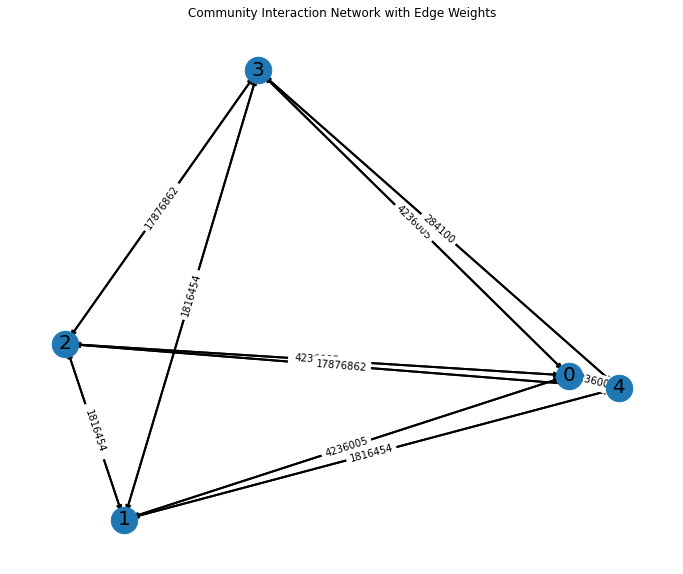

In [21]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes for each community
communities = range(5)  # Assuming there are 5 communities (0 to 4)
G.add_nodes_from(communities)

# Add edges based on retweet and quote counts between communities
for i in communities:
    for j in communities:
        if i != j:
            retweet_count = df_tweets['retweet_count_by_community_{}'.format(j)].sum()
            quote_count = df_tweets['quote_count_by_community_{}'.format(j)].sum()
            G.add_edge(i, j, weight=retweet_count + quote_count)

# Draw the graph
plt.figure(figsize=(12, 10), facecolor='white')
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Community Interaction Network with Edge Weights")
plt.axis('off')  # Turn off the axis
plt.show()

Analyzing the Role of Suspended Users

In [23]:
# Total retweet and quote count by suspended users
total_retweet_by_suspended = df_tweets['retweet_count_by_suspended_users'].sum()
total_quote_by_suspended = df_tweets['quote_count_by_suspended_users'].sum()

# Total retweet and quote count in the dataset
total_retweet = df_tweets['retweet_count_metadata'].sum()
total_quote = df_tweets['quote_count_metadata'].sum()

# Proportion
proportion_retweet = total_retweet_by_suspended / total_retweet
proportion_quote = total_quote_by_suspended / total_quote

print(f"Proportion of retweets by suspended users: {proportion_retweet:.2f}")
print(f"Proportion of quotes by suspended users: {proportion_quote:.2f}")


Proportion of retweets by suspended users: 0.15
Proportion of quotes by suspended users: 0.11


Identify the Most Influential (but banned) Users

In [83]:
# Aggregate the retweet and quote counts for each user
user_influence = df_tweets.groupby('tweet_id').agg({
    'retweet_count_metadata': 'sum',
    'quote_count_metadata': 'sum',
    'user_active_status': 'first' 
}).reset_index()

# Calculate the total influence for each user
user_influence['total_influence'] = user_influence['retweet_count_metadata'] + user_influence['quote_count_metadata']

# Filter for suspended users and sort by total influence
suspended_influential_tweets = user_influence[user_influence['user_active_status'] == 'suspended']
suspended_influential_tweets_sorted = suspended_influential_tweets.sort_values(by='total_influence', ascending=False)

# Get the tweet IDs of the top 100000 influential tweets
top_influential_suspended_tweet_ids = suspended_influential_tweets_sorted.head(100000)['tweet_id']

print(top_influential_suspended_tweet_ids.head())


7075659    1337745268591259648
4736310    1332352538855747584
7485604    1338871862315667456
3830462    1330148622898515969
6735662    1336811823232921600
Name: tweet_id, dtype: int64


What the network have looked if these users had been removed earlier

In [60]:
# Calculate the total influence of the top 100,000 suspended users
total_influence_suspended = suspended_influential_tweets_sorted.head(100000)['total_influence'].sum()

# Calculate the total influence in the entire dataset
total_influence_all = df_tweets['retweet_count_metadata'].sum() + df_tweets['quote_count_metadata'].sum()

# Proportion of influence by top suspended users
proportion_influence_suspended = total_influence_suspended / total_influence_all

print(f"Proportion of influence by top 100,000 suspended users: {proportion_influence_suspended:.2f}")


Proportion of influence by top 100,000 suspended users: 0.29


In [84]:
# Average retweets and quotes per tweet before removal
avg_retweets_before = df_tweets['retweet_count_metadata'].mean()
avg_quotes_before = df_tweets['quote_count_metadata'].mean()

# Remove the tweets from the top 100,000 suspended users
# df_tweets_reduced = df_tweets[~df_tweets.index.isin(top_influential_suspended_tweet_ids)]
df_tweets_reset = df_tweets.reset_index()
df_tweets_reduced = df_tweets_reset[~df_tweets_reset['tweet_id'].isin(top_influential_suspended_tweet_ids)]

# Average retweets and quotes per tweet after removal
avg_retweets_after = df_tweets_reduced['retweet_count_metadata'].mean()
avg_quotes_after = df_tweets_reduced['quote_count_metadata'].mean()

print(f"Average retweets per tweet before: {avg_retweets_before}, after: {avg_retweets_after}")
print(f"Average quotes per tweet before: {avg_quotes_before}, after: {avg_quotes_after}")


Average retweets per tweet before: 5.347165229775264, after: 3.869406164356267
Average quotes per tweet before: 0.5740411513562291, after: 0.41942873501803185
